### based on https://huggingface.co/docs/transformers/en/tasks/image_classification

In [1]:
!pip install transformers datasets evaluate

# Load Food-101 dataset

In [2]:
from datasets import load_dataset

# limit dataset size to decrease training time during the workshop
food = load_dataset("food101", split="train[:2500]")

In [3]:
food = food.train_test_split(test_size=0.2)

In [4]:
food["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=384x512>,
 'label': 81}

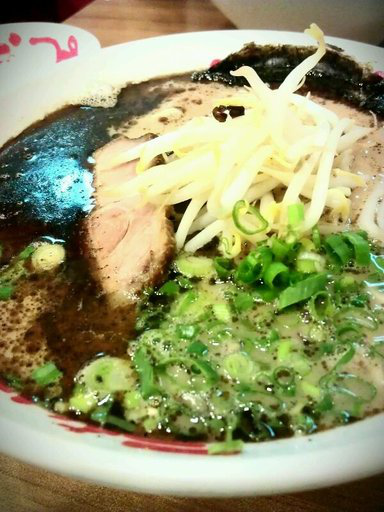

In [5]:
food["train"][0]["image"]

In [6]:
# create a dictionary that maps the label name to an integer and vice versa
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [7]:
id2label[str(food["train"][0]["label"])]

'ramen'

# Preprocess

In [8]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [9]:
# apply data augmentation to prevent overfitting
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor, Resize

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

_transforms_inference = Compose([Resize(size), ToTensor(), normalize])

In [10]:
# apply transforms and return pixel values
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

def transforms_inference(examples):
    examples["pixel_values"] = [_transforms_inference(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [11]:
food = food.with_transform(transforms)

In [12]:
food

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 500
    })
})

In [13]:
# create a batch of examples
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

# Evaluate

In [14]:
!pip install scikit-learn

In [15]:
import evaluate

accuracy = evaluate.load("accuracy")

In [16]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# Train

In [17]:
# Load ViT model with specified number of classes
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# set training parameters
training_args = TrainingArguments(
    output_dir="my_awesome_food_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

/home/alex/miniconda3/envs/pytorch_cuda_11.8/lib/python3.12/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [19]:
trainer.train()

/home/alex/miniconda3/envs/pytorch_cuda_11.8/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1711403463728/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch,Training Loss,Validation Loss,Accuracy
0,3.078700,2.788279,0.862000
1,2.187700,2.098037,0.852000
2,1.901000,1.925405,0.854000


TrainOutput(global_step=93, training_loss=2.693537747988137, metrics={'train_runtime': 355.4414, 'train_samples_per_second': 16.88, 'train_steps_per_second': 0.262, 'total_flos': 4.616415762481152e+17, 'train_loss': 2.693537747988137, 'epoch': 2.98})

# Inference

In [20]:
ds = load_dataset("food101", split="validation[:10]")

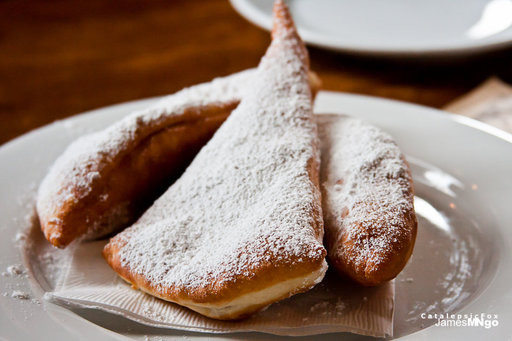

In [21]:
ds["image"][9]

In [22]:
id2label[str(ds["label"][9])]

'beignets'

In [23]:
ds_processed = ds.with_transform(transforms_inference)

In [25]:
inference_result = trainer.predict(ds_processed)

In [26]:
inference_result

PredictionOutput(predictions=array([[-9.13443491e-02, -1.38118461e-01, -4.80900053e-06, ...,
        -2.02097803e-01, -1.06737040e-01, -5.43858111e-02],
       [-9.73377228e-02, -7.85419121e-02,  7.02805147e-02, ...,
        -1.22578315e-01, -1.71853676e-01, -3.52695994e-02],
       [-1.27827942e-01, -1.17288820e-01,  1.84493348e-01, ...,
        -1.06789559e-01, -6.31865785e-02, -3.71819399e-02],
       ...,
       [-1.26924261e-01, -1.21879064e-01,  1.40915856e-01, ...,
        -1.38628602e-01,  1.12704504e-02, -3.05708535e-02],
       [ 2.31549107e-02, -5.52280471e-02,  1.14892222e-01, ...,
        -1.68496415e-01, -2.01244712e-01, -1.46085560e-01],
       [-1.10813692e-01, -1.29291594e-01,  1.92938760e-01, ...,
        -1.40440971e-01,  5.37143387e-02, -1.63825527e-02]], dtype=float32), label_ids=array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6]), metrics={'test_loss': 2.590039014816284, 'test_accuracy': 0.9, 'test_runtime': 0.275, 'test_samples_per_second': 36.367, 'test_steps_per_second': 3.6

In [27]:
for i, logits in enumerate(inference_result.predictions):
    predicted_id = np.argmax(logits)
    print(f"predicted: {predicted_id} ({id2label[str(predicted_id)]}); ground_truth: {inference_result.label_ids[i]}")
    

predicted: 6 (beignets); ground_truth: 6
predicted: 6 (beignets); ground_truth: 6
predicted: 6 (beignets); ground_truth: 6
predicted: 6 (beignets); ground_truth: 6
predicted: 6 (beignets); ground_truth: 6
predicted: 6 (beignets); ground_truth: 6
predicted: 6 (beignets); ground_truth: 6
predicted: 6 (beignets); ground_truth: 6
predicted: 79 (prime_rib); ground_truth: 6
predicted: 6 (beignets); ground_truth: 6


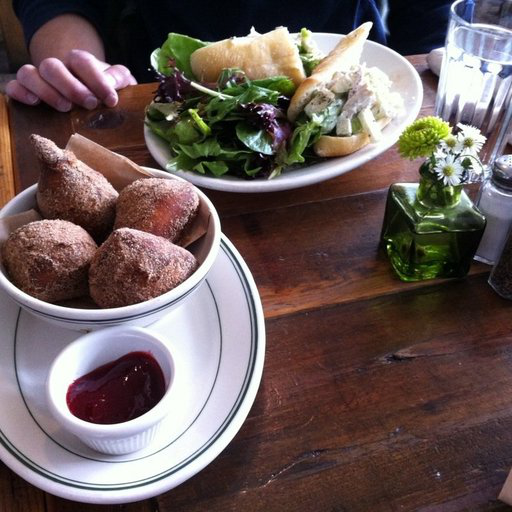

In [28]:
ds["image"][-2]